<a href="https://colab.research.google.com/github/salmonin-o3o/ESAA_study/blob/main/ESAA1216_markdown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 05. DBSCAN
### DBSCAN 개요
DBSCAN(Density Based Spatial Clustering of Applications with Noise)는 밀도 기반 군집화의 대표적인 알고리즘으로, 간단하고 직관적인 알고리즘으로 되어있음에도 데이터의 분포가 기하학적으로 복잡한 데이터 세트에도 효과적인 군집화가 가능하다.

**주요 파라미터**
- 입실론 주변 영역(epsilon): 개별 데이터를 중심으로 입실론 반경을 가지는 원형의 영역이다. -> eps
- 최소 데이터 개수(min points): 개별 데이터의 입실론 주변 영역에 포함되는 타 데이터의 개수이다. -> min_samples

**데이터 포인트**
- 핵심 포인트(Core Point): 주변 영역 내에 최소 데이터 개수 이상의 타 데이터를 가지고 있을 경우 해당 데이터를 핵심 포인트라고 한다.
- 이웃 포인트(Neighbor Point): 주변 영역 내에 위치한 타 데이터를 이웃 포인트라고 한다.
- 경계 포인트(Border Point): 주변 영역 내에 최소 데이터 개수 이상의 이웃 포인트를 가지고 있지 않지만 핵심 포인트를 이웃 포인트로 가지고 있는 데이터를 경계 포인트라고 한다.
- 잡음 포인트(Noise Point): 최소 데이터 개수 이상의 이웃 포인트를 가지고 있지 않으며, 핵심 포인트도 이웃 포인트로 가지고 있지 않는 데이터를 잡음 포인트라고 한다.

### DBSCAN 적용하기 - 붓꽃 데이터 세트

In [1]:
from sklearn.datasets import load_iris
import pandas as pd

iris = load_iris()
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# 좀 더 편리한 데이터 Handling을 위해 DataFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target'] = iris.target

In [2]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.6, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

target  dbscan_cluster
0        0                49
        -1                 1
1        1                46
        -1                 4
2        1                42
        -1                 8
Name: count, dtype: int64


-1은 노이즈에 속하는 군집을 의미.
원래 군집은 3개이지만, 2개로 분리되었음.

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    """
    군집화 결과 또는 make_blobs 데이터를 시각화하는 함수

    Parameters:
    - clusterobj: 사이킷런의 군집 수행 객체 (KMeans, GaussianMixture 등). 군집화가 아닌 make_blobs 데이터를 시각화할 경우 None
    - dataframe: 피처 데이터와 레이블을 포함하는 DataFrame
    - label_name: 군집화 결과 레이블 또는 make_blobs 결과 타깃의 칼럼명
    - iscenter: 군집 중심 좌표 시각화 여부 (KMeans 등에서 지원). True일 경우 군집 중심을 표시
    """
    # 산점도 색상 설정
    unique_labels = np.unique(dataframe[label_name])
    colors = sns.color_palette('hsv', len(unique_labels))

    # 군집 중심 좌표
    centers = None
    if iscenter and clusterobj is not None and hasattr(clusterobj, 'cluster_centers_'):
        centers = clusterobj.cluster_centers_

    # 산점도 그리기
    plt.figure(figsize=(10, 7))
    for label, color in zip(unique_labels, colors):
        cluster_data = dataframe[dataframe[label_name] == label]
        plt.scatter(
            cluster_data.iloc[:, 0],  # 첫 번째 피처
            cluster_data.iloc[:, 1],  # 두 번째 피처
            s=50,
            c=[color],
            label=f'Cluster {label}'
        )

    # 군집 중심 좌표 시각화
    if centers is not None:
        plt.scatter(
            centers[:, 0],
            centers[:, 1],
            s=250,
            c='red',
            marker='*',
            label='Centers'
        )

    # 그래프 꾸미기
    plt.title('Cluster Visualization', fontsize=15)
    plt.xlabel('Feature 1', fontsize=12)
    plt.ylabel('Feature 2', fontsize=12)
    plt.legend()
    plt.show()

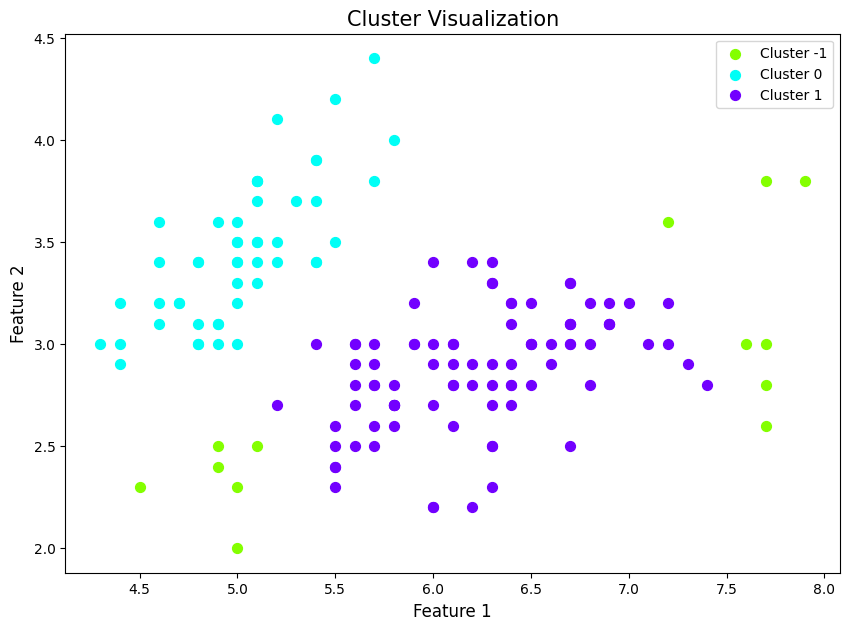

In [4]:
from sklearn.decomposition import PCA
# 2차원으로 시각화하기 위해 PCA n_components=2로 피처 데이터 세트 변환
pca = PCA(n_components=2, random_state=0)
pca_transformed = pca.fit_transform(iris.data)
# visualize_cluster_plot() 함수는 frt1, ftr2 칼럼을 좌표에 표현하므로 PCA 변환값을 해당 ㅏㄹ럼으로 생성
irisDF['ftr1'] = pca_transformed[:,0]
irisDF['ftr2'] = pca_transformed[:,1]

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

이상치인 노이즈 데이터가 명확이 드러난다. DBSCAN을 적용할 때는 특정 군집 개수로 군집을 강제하지 않는 것이 좋으며, 알고리즘에 적절한 eps와 min_samples 파라미터를 통해 최적의 군집을 찾는 게 중요하다.

eps의 값을 크게 하면 반경이 커져 노이즈 데이터 개수가 작아진다.

target  dbscan_cluster
0        0                50
1        1                50
2        1                47
        -1                 3
Name: count, dtype: int64


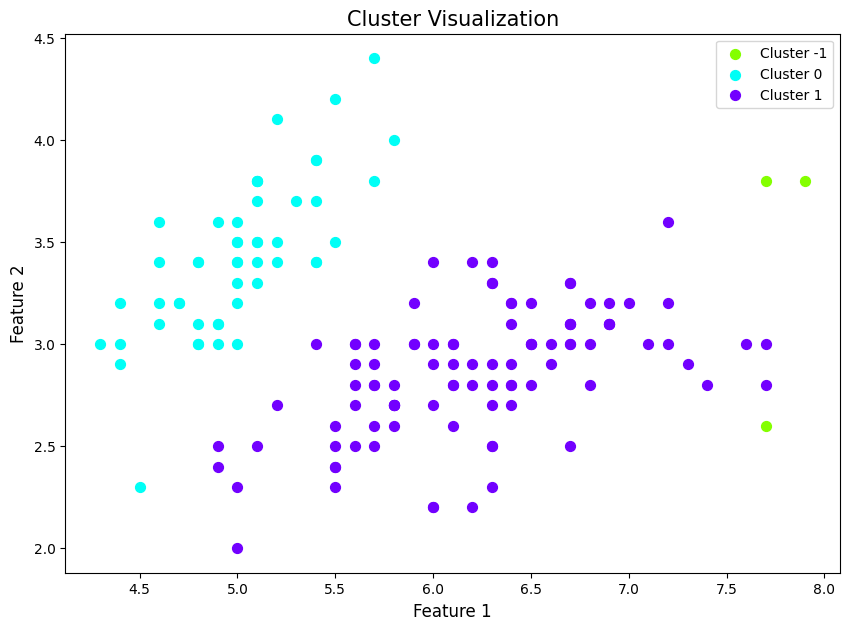

In [5]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.8, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

min_samples를 크게 하면 노이즈 데이터 개수가 커지게 된다.

target  dbscan_cluster
0        0                48
        -1                 2
1        1                44
        -1                 6
2        1                36
        -1                14
Name: count, dtype: int64


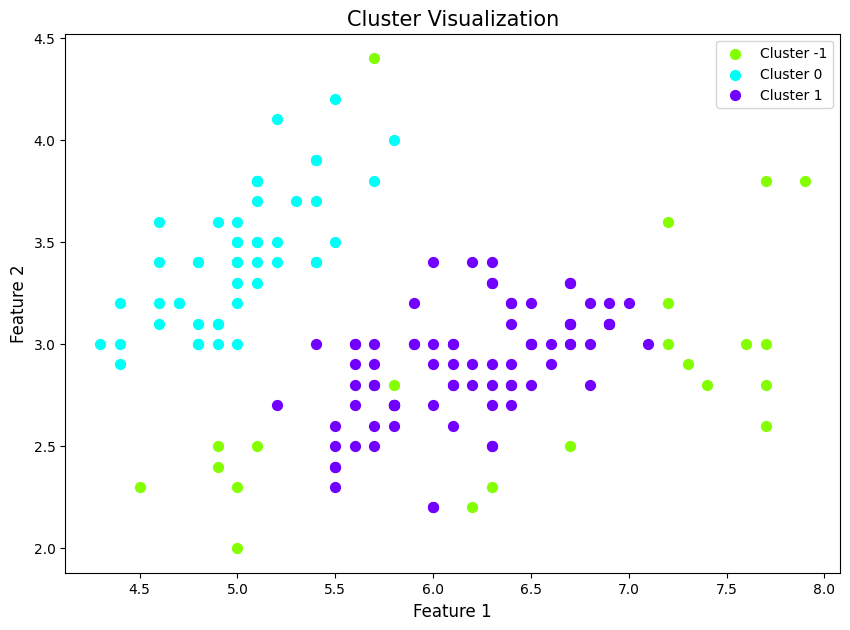

In [6]:
dbscan = DBSCAN(eps=0.6, min_samples=16, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

### DBSCAN 적용하기 - make_circles() 데이터 세트
make_circles() 함수를 이용해 내부 원과 외부 원 형태로 되어있는 2차원 데이터 세트를 만들어보자. 이때 DBSCAN과 타 알고리즘을 비교해본다.

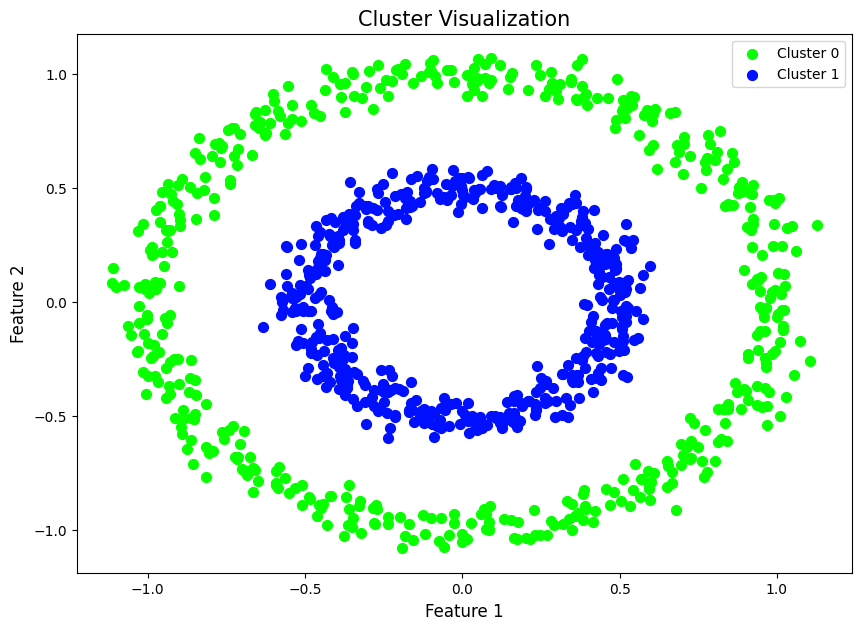

In [7]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, shuffle=True, noise=0.05, random_state=0, factor=0.5)
clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

K-평균으로 군집화

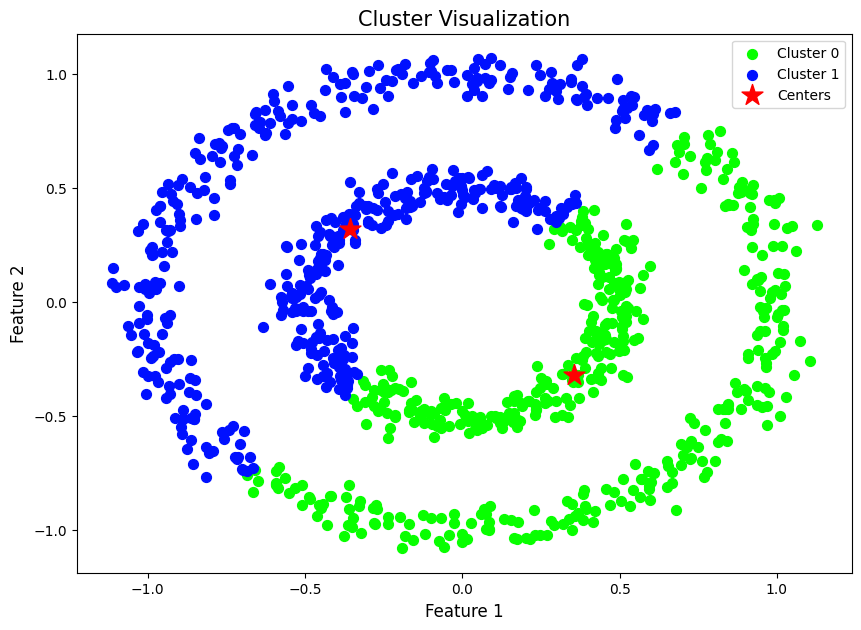

In [8]:
# KMeans로 make_circles() 데이터 세트를 군집화 수행.
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, max_iter=1000, random_state=0)
kmeans_labels = kmeans.fit_predict(X)
clusterDF['kmeans_cluster'] = kmeans_labels

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_cluster', iscenter=True)

GMM 적용

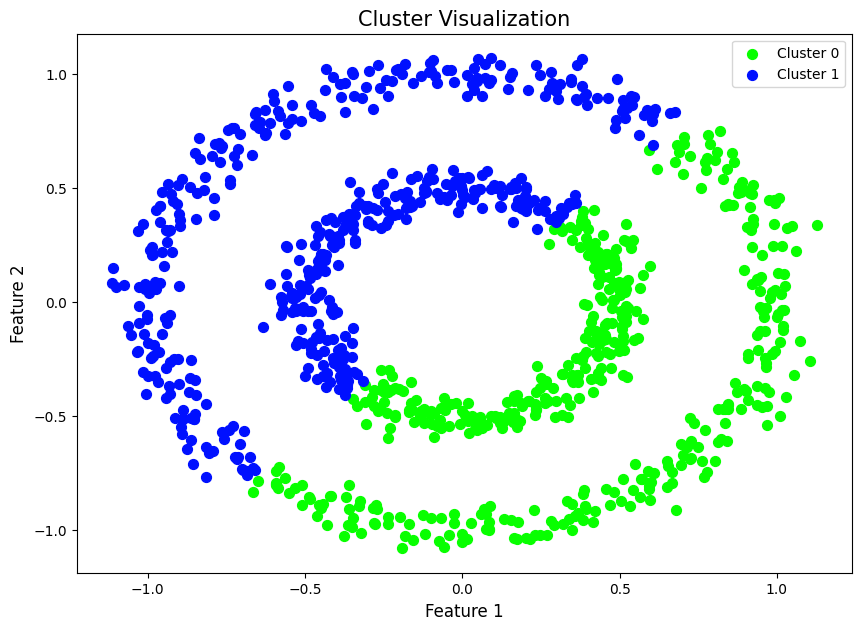

In [9]:
# GMM으로 make_circles() 데이터 세트를 군집화 수행.
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=0)
gmm_label = gmm.fit(X).predict(X)
clusterDF['gmm_cluster'] = gmm_label

visualize_cluster_plot(gmm, clusterDF, 'gmm_cluster', iscenter=False)

DBSCAN 적용

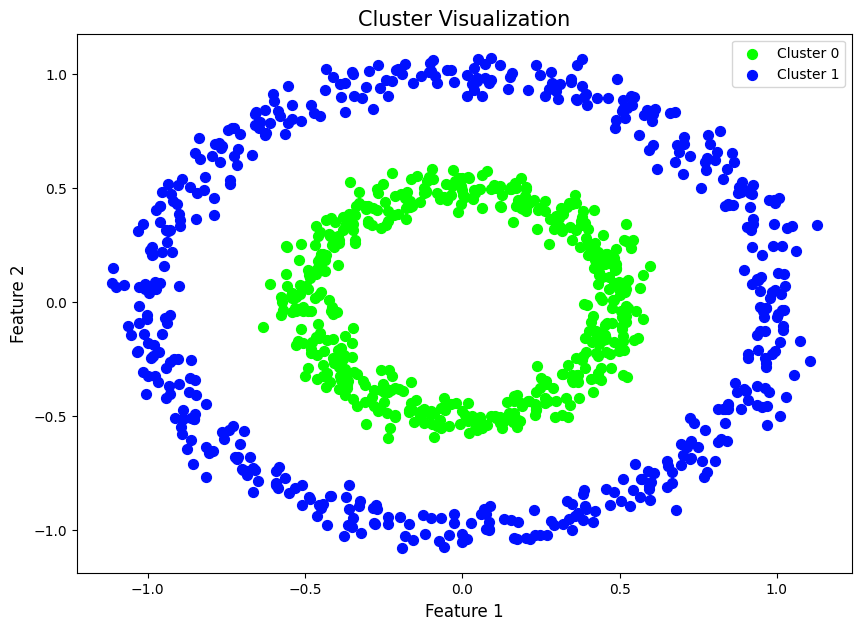

In [10]:
# DBSCAN으로 make_circles() 데이터 세트 군집화 수행.
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=10, metric='euclidean')
dbscan_labels = dbscan.fit_predict(X)
clusterDF['dbscan_cluster'] = dbscan_labels

visualize_cluster_plot(dbscan, clusterDF, 'dbscan_cluster', iscenter=False)

## 06. 군집화 실습 - 고객 세그먼테이션
### 고객 세그먼테이션의 정의와 기법
고객 세그먼테이션은 고객의 어떤 요소를 기반으로 군집화할 것인가를 결정하는 것이 중요한데, 여기서는 기본적인 고객 분석 요소인 RFM 기법을 이용한다.
- RECENCT(R): 가장 최근 상품 구입 일에서 오늘까지의 기간
- FREQUENCY(F): 상품 구매 횟수
- MONETARY VALUE(M): 총 구매 금액

### 데이터 세트 로딩과 데이터 클렌징


In [11]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')
retail_df = pd.read_excel(io="/content/drive/My Drive/pythonprogramming/ESAA/Online Retail.xlsx")
retail_df.head(3)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [12]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


- Null 데이터 제거: 고객 식별 번호가 없는 데이터는 삭제한다.
- 오류 데이터 제거: Quantity 또는 UnitlPrice가 0보다 작은 경우를 삭제한다. 이 경우 invoiceNo의 앞자리가 'C'이다.

In [13]:
retail_df = retail_df[retail_df['Quantity'] > 0]
retail_df = retail_df[retail_df['UnitPrice'] > 0]
retail_df = retail_df[retail_df['CustomerID'].notnull()]
print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [14]:
retail_df['Country'].value_counts()[:5]

,count
Country,
United Kingdom,354321
Germany,9040
France,8341
EIRE,7236
Spain,2484


영국만 남기기.

In [15]:
retail_df = retail_df[retail_df['Country'] == 'United Kingdom']
print(retail_df.shape)

(354321, 8)


### RFM 기반 데이터 가공
사전 정제된 데이터 기반으로 고객 세그먼테이션 군집화를 RFM 기반으로 수행한다. 그 전에, 'UnitPrice'와 'Quantity'를 곱해서 주문 금액 데이터를 만들고, CustomerNo더 int형으로 변경한다.

In [16]:
retail_df['sale_amount'] = retail_df['Quantity'] * retail_df['UnitPrice']
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

<ipython-input-16-879155f23e07>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail_df['sale_amount'] = retail_df['Quantity'] * retail_df['UnitPrice']
<ipython-input-16-879155f23e07>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)


In [17]:
print(retail_df['CustomerID'].value_counts().head(5))
print(retail_df.groupby('CustomerID')['InvoiceNo'].sum().sort_values(ascending=False)[:5])

CustomerID
17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: count, dtype: int64
CustomerID
17841    4418581314
14096    2933997631
12748    2591768347
14606    1501891387
15311    1323212209
Name: InvoiceNo, dtype: object


In [18]:
retail_df.groupby(['InvoiceNo', 'StockCode'])['InvoiceNo'].count().mean()

1.028702077315023

주문번호+상품코드 기준의 데이터를 Recency, Frequency, Monetary value 데이터로 변경한다.

In [19]:
# DataFrame의 groupby()의 multiple 연산을 위해 agg() 이용
# Recency는 InvoiceDate 칼럼의 max()에서 데이터 가공
# Frequency는 InvoiceNo 칼럼의 count(), Monetary value는 sale_amount 칼럼의 sum()
aggregations = {
    'InvoiceDate': 'max',
    'InvoiceNo': 'count',
    'sale_amount': 'sum'
}
cust_df = retail_df.groupby('CustomerID').agg(aggregations)
# groupby된 결과 칼럼 값을 Recency, Frequency, Monetary로 변경
cust_df = cust_df.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'sale_amount': 'Monetary'
})
cust_df = cust_df.reset_index()
cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73


Recency 칼럼을 가공한다.

In [20]:
import datetime as dt

cust_df['Recency'] = dt.datetime(2011, 12, 10) - cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x: x.days+1)
print('cust_df 로우와 칼럼 건수는', cust_df.shape)
cust_df.head(3)

cust_df 로우와 칼럼 건수는 (3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73


### RFM 기반 고객 세그먼테이션


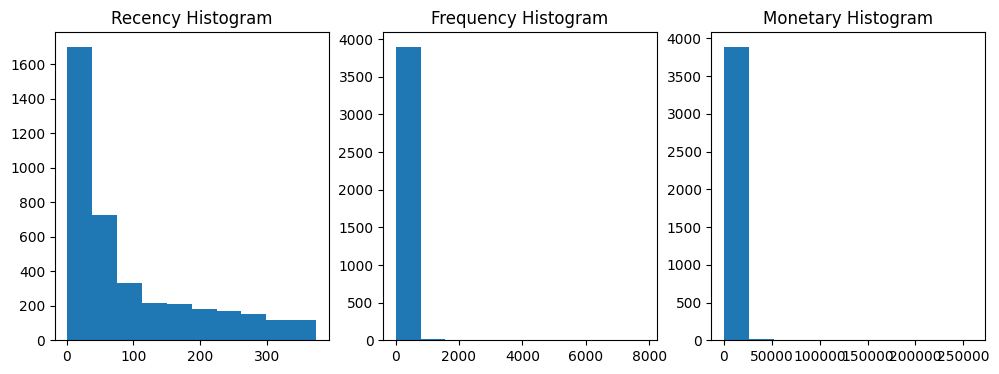

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])
plt.show()

왜곡 정도가 매우 심함.

In [22]:
cust_df[['Recency', 'Frequency', 'Monetary']].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


K-평균을 수행해보자.

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features = cust_df[['Recency', 'Frequency', 'Monetary']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

실루엣 스코어는 : 0.576


In [24]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

def visualize_silhouette(cluster_lists, X_features):
    """
    여러 개의 군집 개수에 대해 KMeans 군집화와 실루엣 계수를 시각화합니다.

    Parameters:
    cluster_lists: list
        군집 개수로 사용할 정수 리스트 (예: [2, 3, 4, 5])
    X_features: array-like
        군집화에 사용할 피처 데이터 세트
    """
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(1, n_cols, figsize=(4 * n_cols, 6))

    if n_cols == 1:
        axs = [axs]  # 단일 subplot에도 리스트로 접근 가능하도록 처리

    for idx, n_clusters in enumerate(cluster_lists):
        # KMeans 모델 학습 및 예측
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        cluster_labels = kmeans.fit_predict(X_features)

        # 실루엣 계수 계산
        silhouette_avg = silhouette_score(X_features, cluster_labels)
        sample_silhouette_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[idx].set_title(f"Clusters: {n_clusters}\nAvg Silhouette: {silhouette_avg:.2f}")
        axs[idx].set_xlim([-0.1, 1])
        axs[idx].set_ylim([0, len(X_features) + (n_clusters + 1) * 10])
        axs[idx].set_xlabel("Silhouette Coefficient Values")
        axs[idx].set_ylabel("Cluster Label")

        # 각 군집별 실루엣 계수 플롯
        for i in range(n_clusters):
            cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            cluster_silhouette_values.sort()

            size_cluster_i = cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            axs[idx].fill_betweenx(
                np.arange(y_lower, y_upper),
                0, cluster_silhouette_values,
                facecolor=color, edgecolor=color, alpha=0.7
            )

            axs[idx].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10  # 10은 클러스터 간의 공백

        axs[idx].axvline(x=silhouette_avg, color="red", linestyle="--")
        axs[idx].set_yticks([])  # y축 틱 제거
        axs[idx].set_xticks(np.arange(-0.1, 1.1, 0.2))

    plt.tight_layout()
    plt.show()

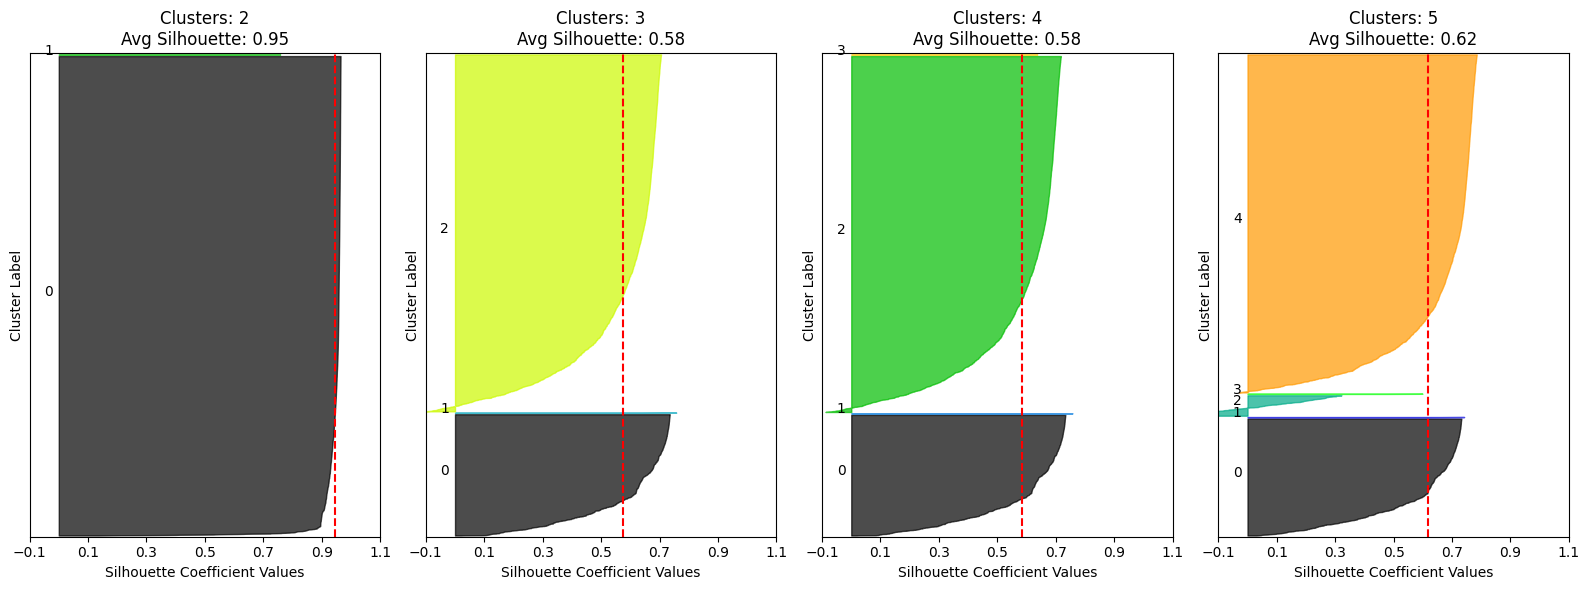

NameError: name 'visualize_kmeans_plot_multi' is not defined

In [25]:
visualize_silhouette([2, 3, 4, 5], X_features_scaled)
visualize_kmeans_plot_multi([2, 3, 4, 5], X_features_scaled)

데이터 세트의 왜곡 정도를 낮추기 위해 데이터 값에 로그를 적용하자.

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Recency, Frequency, Monetary 칼럼에 np.log1p()로 Log Transformation
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

# Log Transformation 데이터에 StandardScaler 적용
X_features = cust_df[['Recency_log', 'Frequency_log', 'Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

실루엣 스코어는 : 0.303


## 07. 정리
이번 장에서는 다양한 머신러닝의 기반의 군집화 기법을 배웠다. K-평균은 거리 기반으로 군집 중심점을 이동시키면서 군집화를 수행한다. 평균 이동은 데이터가 모여있는 밀도가 가장 높은 쪽으로 군집점을 이동하면서 군집화를 수행한다. GMM은 데이터가 여러개의 가우시안 분포를 섞어서 생성된 모델로 가정해 수행하는 방식이다. DBSCAN은 밀도 기반 군집화의 대표적인 알고리즘이다.